Ejercicio 2
--

In [3]:
import os
import pathlib
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib as mpl
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from keras.callbacks import ModelCheckpoint
from keras import backend as K

#constantes usadas durante este ejercicio cuyos valores se han decidido después de un estudio de los datos
IMG_SIZE = 224
NUM_CLASSES = 5
BATCH_SIZE = 32
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

Para comenzar cargamos los datos directamente desde keras usando la función load predefinida. Con:
    - as_supervised le decimos que nos descargue también las etiquetas, 
    - con split le indicamos que nos divida ya directamente el conjunto de datos en train, validation y test 
    (las proporciones dadas por defecto en el ejercicio son adecuadas para tales conjuntos)
    - con  shuffle_files le pedimos que nos mezcle los datos. 
    Siempre es importante mezclar los datos (siempre y cuando sean sean independientes unos ejemplos de otros) 
        para evitar sobreentrenamientos o una representación no adecuada (por ejemplo un train con la mayoría 
              de ejemplos de un tipo y apenas de otro).
    - definimos el batch_size por defecto a 32, que es un tamaño adecuado para estos problemas.

In [4]:
"""
Load this dataset in directly in memory using tfds as follows:
"""
(train_datasets, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
    shuffle_files = True,
    batch_size=BATCH_SIZE,
)

Lo primero es necesario hacer un estudio del conjunto de datos, familiarizarse con el problema y observar sus características. Conviene calcular estadísticas, visualizar algunas imágenes, comprobar si nos topamos con "labels" y ver en qué formato vienen definidas.

En este caso en concreto, nos encontramos un con conjunto de datos relativamente balanceado pero no muchos ejemplos. Tenemos 5 clases que corresponden a los 5 tipos diferentes de flor que vienen codificadas de 0 a 4 en la etiqueta label.

También es recomendable para estudiar el data set visualizar los datos

In [5]:
#list(train_datasets.as_numpy_iterator())
print(metadata)#Vamos a imprimir un poco de información sobre el conjunto de datos que acabamos de leer.

tfds.core.DatasetInfo(
    name='tf_flowers',
    full_name='tf_flowers/3.0.1',
    description="""
    A large set of images of flowers
    """,
    homepage='https://www.tensorflow.org/tutorials/load_data/images',
    data_path='/home/users/rpierrard/tensorflow_datasets/tf_flowers/3.0.1',
    download_size=218.21 MiB,
    dataset_size=221.83 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=5),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=3670, num_shards=2>,
    },
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflow.org/example_images/flower_photos.tgz" }""",
)


Una vez completados los pasos previos, procedemos a la etapa de preprocesamiento de los datos. En ella he realizado dos tareas:

1- resize_normalize: dado que voy a trabajar con CNN (que es la arquitectura de NN más recomendable y desarrollada para procesamiento de imágenes), las imágenes de entrada para el entrenamiento y test deben tener el mismo tamaño. Es muy recomendable normalizar dichas imágenes pues la definición matemática de estos modelos tolera y reacciona mejor a numéros pequeños que a grandes cantidades. 
Codificamos con one hot encoder la label de cada imagen para que tome como formato de salida un array de 5 posiciones

2- augmentation: en computer vision siempre es una técnica importante para entrenar modelos robustos. Evita el overfitting y ayuda al modelo a extraer mejor las features (características) únicas de las clases en el conjunto de datos. 

Mejoras:
------------
Por falta de tiempo no he podido implementar todo lo que me hubiera gustado. En este punto por ejemplo añadiría la función de generación de imágenes con perturbaciones para crear imágenes adversariales que agregaría a los conjunto de datos.
También añadiría más técnicas de data augmentation para generar nuevas imágenes las cuales añadiría a los conjuntos de datos.

In [6]:
def resize_normalize(image, label):
    image = tf.cast(image, tf.float32)
    # Normalize the pixel values
    image = image / 255.0
    # Resize the image
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    label = tf.one_hot(label,5)
    return image, label


def augmentation(image, label):  
  image = tf.image.random_flip_left_right(image)  
  image = tf.image.random_contrast(image, lower=0.0, upper=1.0)  
  return image,label

#poner la generación de imágenes adversariales desarrolado en el ejercicio 1

train = train_datasets.map(resize_normalize)
train = train.map(augmentation) #to improve the model we can consider applying on the fly augmentations instead of generating augmented dataset
validation = val_ds.map(resize_normalize)
test = test_ds.map(resize_normalize)

#len(list(train.as_numpy_iterator()))

Aquí viene la parte interesante. ¿Qué arquitectura elegimos?, ¿cómo entrenamos?

Tenemos 2 opciones:
    1- generar una arquitectura por nuestra cuenta desde cero, entrenarla en un conjunto rico de datos y dedicar mucho tiempo y recursos a mejorarla.
    2- Emplear un modelo bueno ya pre-entrenado sobre un gran conjunto de imágenes (imagenet). Hoy en día se usa mucho esta opción: se escoje un modelo pre-entrenado (en datos similares) como extractor de características y se tunea (fine tuning) usando nuestro conjunto de datos
    
Por desgracia no dispongo de ninguna GPU, luego haber optado por la primera opción me habría llevado días, semanas... Por lo tanto he decidido utilizar la arquitectura propuesta en el ejercicio 1 (mobileNetV2) como extractor de características. Un modelo más complejo como extractor de características hubiera dado mejores resultados, pero dado que sólo tengo unas horas para hacer este test, he escogido mobileNetV2 al ser un modelo más ligeros (diseñado para dispositivos móviles) y que tarda menos tiempo en operar.

Definimos algunas métricas que keras no tiene disponibles para evaluar nuestros resultados y proceso de aprendizaje: el recall, precision y f1 (ver wikipedia para más detalles).

In [7]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

Ahora vamos a generar el modelo y entrenarlo (mirar por favor comentarios en el código):

1) Generamos el extractor de características mobilNet2 y congelamos los pesos, el extractor de caracteristicas no lo vamos a entrenar. include_top=False nos devuelve únicamente el extractor y no el clasificador al completo como en el ejercicio 1.

2) Generamos un modelo con varias capas: 
    - extractor de características pre-entrenado (mobilNetV2)
    - una capa con una convolución2D y activación relu (usada en convoluciones)
    - un dropout como técnica de regularización (para evitar el overfitting)
    - una dense layer con función softmax que contenga 5 salidas. Cada una dará como resultado el intervalo de confianza que la red tiene al determinar que la imagen pertenece a la clase correspondiente a dicha salida (por ello se ha utilizado el one hot encoder para codificar las labels).
    
3) Después compilamos el modelo usando varias métricas definidas previamente, así como la loss y el accuracy.
    He usado el optimizador ADAM pues es uno de los que mejor se comporta en estos casos. Ajusta la tasa de aprendizaje durante el mismo y usa el momentum para suavizar el descenso del gradiente. He escogido una learning rate de 0.0001 en lugar de 0.001 (que viene por defecto) pues parto de una red ya entrenada en extracción de características, nos interesa que el proceso de aprendizaje no experimente variaciones bruscas pues ya partimos de una buena base gracias a mobilNetV2.

4) Establecemos 50 epochs. También habilitamos la funcionalidad de checkpoints para guardar modelso intermedios que se generen durante el entrenamiento y que puedan ser más satisfactorios.

5) Entrenamos usando nuestros conjuntos de de train y validación.

In [8]:
# Creamos el modelo desde el pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                              include_top=False, 
                                              weights='imagenet')
base_model.trainable = False #congelamos los pesos, el extractor de caracteristicas no lo vamos a entrenar

#generamos nuestra arquitecture
model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.GlobalAveragePooling2D(),
#   tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(5, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001), 
             # loss='sparse_categorical_crossentropy', 
               loss='categorical_crossentropy', 
#              metrics=['accuracy']
             metrics=['acc',f1_m,precision_m, recall_m])


model.summary()

EPOCHS = 50

checkpoint = ModelCheckpoint('./model/model-{epoch:03d}-{acc:03f}-{val_loss:03f}.h5', verbose=1, monitor='val_loss',save_best_only=True, mode='auto')  

#history = model.fit(train, validation_data=validation, batch_size=BATCH_SIZE, callbacks=[checkpoint], epochs=30)    

history = model.fit(train, 
                    callbacks = [checkpoint],
                    epochs=EPOCHS, 
                    validation_data=validation)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
conv2d (Conv2D)              (None, 5, 5, 32)          368672    
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 32)          0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 5)                 165       
Total params: 2,626,821
Trainable params: 368,837
Non-trainable params: 2,257,984
_________________________________________________________________
Epoch 1/50
92/92 [==============================] - 13s 109ms/step - loss: 1.2472 - acc: 0.4791 - f1_m: 0.

He realizado varios experimentos probando diferentes epochs, learning rates, capas de convoluciones o regularizaciones.

En "trainmobilNetv2+dense.png" se puede encontrar una imagen de un entrenamiento en el que sólo he usado el extractor de características y la dense layer. Se puede observar como a partir de cierto momento se produce un overfitting. Ese efector observado me ha llevado a añadir más capas al modelo para regularizar. En los resultados que se exponen a continuación se puede ver como efectivamente hemos mejorado.

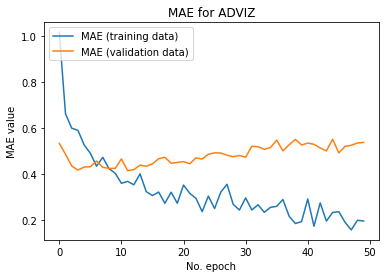

In [9]:
print(history)

# Plot history: MAE
plt.plot(history.history['loss'], label='MAE (training data)')
plt.plot(history.history['val_loss'], label='MAE (validation data)')
plt.title('MAE for ADVIZ')
plt.ylabel('MAE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [10]:
results = model.evaluate(test)

12/12 [==============================] - 1s 63ms/step - loss: 0.4709 - acc: 0.8638 - f1_m: 0.8642 - precision_m: 0.8699 - recall_m: 0.8587


Los pasos escogidos me han llevado a un accuracy del 87% en clasificación en test.

Mejoras:
--
Estos resultados Si hubiera tenido más tiempo y recursos hubiera:
- usado un modelo más potente al mobilNetV2 como extractor de características (ResNext por ejemplo). Hoy en día los transformers están revolucionando el mundo del DL, en cambio son muy costosos en cuanto a cómputos y realmente sacan partido de sus ventajas en paralelización cuando se disponen de varios nodos de computación donde se puedan ejecutar. Como no es mi caso, yo no los uso.
- probado con más métodos de data augmentation
- incluido la generación de imágenes adversariales en los conjuntos de datos para que la red aprenda a detectarlos bien
- usado más la regularización así como otros parámetros de entrenamiento
- hecho un estudio del conjunto de test más exhaustivo como por ejemplo pintar la matriz de confusión, aplicar un cross validation con unas 5 folds.
- usar los modelo intermedios (generados en la carpeta model) con el checkpoint para comprobar si efectivamente son mejores estudiando su comportamiento en el conjunto de test